# YOLO dataset creation based on Fashion Dataset

### Libraries

In [7]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import torch.nn as nn
import torch
import numpy as np
import pandas as pd

### Directories

In [ ]:
image_path='/mnt/e/jhona/Documents/Estudo/AI Microsfot & Simplon.co/Projet_chef_doeuvre/fashion_dataset/images/'
ds_path = '/mnt/e/jhona/Documents/Estudo/AI Microsfot & Simplon.co/Projet_chef_doeuvre/fashion_dataset/'
yolo_dataset_dir = '/mnt/e/jhona/Documents/Estudo/AI Microsfot & Simplon.co/Projet_chef_doeuvre/fashion_dataset/yolo_dataset/'


## Data cleanning

In [9]:
# Remove lines that are not compliance (10 fields)
file_path = ds_path+"/styles.csv"
file_path_traited = ds_path+"/styles_10_categories.csv"

with open(file_path, "r", encoding="utf-8") as file:
    with open(file_path_traited, "w", encoding="utf-8") as new_file:
        for line in file:
            if line.count(",") <= 9:
                new_file.write(line)
            else:
                print(f"Linha tem mais de 9 vírgulas: {line.strip()}")

Linha tem mais de 9 vírgulas: 44065,Men,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017,Casual,Boss Men Perfume, After Shave Balm and Shower Gel Set
Linha tem mais de 9 vírgulas: 3413,Men,Apparel,Topwear,Tshirts,White,Summer,2011,Casual,Myntra Men's Yes, its all about me White T-shirt
Linha tem mais de 9 vírgulas: 23101,Men,Accessories,Accessories,Accessory Gift Set,Pink,Fall,2011,Formal,Turtle Men Formal Pink Tie, Cufflink and Pocket Square Combo Set
Linha tem mais de 9 vírgulas: 23108,Men,Accessories,Accessories,Accessory Gift Set,Purple,Fall,2011,Formal,Turtle Men Formal Purple Tie, Cufflink and Pocket Square Combo Set
Linha tem mais de 9 vírgulas: 4854,Unisex,Footwear,Shoes,Casual Shoes,White,Winter,2012,Casual,Newfeel Unisex White, Blue and Orange Casual Shoes
Linha tem mais de 9 vírgulas: 23109,Men,Accessories,Accessories,Accessory Gift Set,Purple,Fall,2011,Formal,Turtle Men Formal Purple Tie, Cufflink and Pocket Square Combo Set
Linha tem mais de 9 vírgulas: 23100

In [ ]:
df = pd.read_csv(file_path_traited)

In [ ]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
filter_ds = df[df['masterCategory'].isin(['Apparel'])]
article_df = filter_ds[['id','articleType']]

In [12]:
article_labels = article_df['articleType'].unique()

In [20]:
len(article_labels)

57

## Load Model

In [13]:
model_name = 'sayeed99/segformer_b3_clothes'

In [14]:
# Load the image processor and the pre-trained model for semantic segmentation
processor = SegformerImageProcessor.from_pretrained(model_name)
model = AutoModelForSemanticSegmentation.from_pretrained(model_name)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the selected device

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

### Image labelization based on Segformer B3 model

In [16]:
import os
from PIL import Image
import numpy as np

# Define directories and YOLO image size
os.makedirs(yolo_dataset_dir, exist_ok=True)
yolo_image_size = (height, width) = (640, 640)

# Precompute class mappings for faster lookups
class_mapping = {label: idx for idx, label in enumerate(article_labels)}

for line in article_df.to_numpy():
    # Image path and label
    img_id, label = line[0], line[1]

    source_img = f"{image_path}/{img_id}.jpg"
    yolo_img_path = f"{yolo_dataset_dir}/{img_id}.jpg"
    yolo_label_path = f"{yolo_dataset_dir}/{img_id}.txt"
    
    # Check if the image exists in the source directory
    if not os.path.exists(source_img):
        print(f"Source image not found: {source_img}")
        continue

    # Check if the image already exists in the YOLO directory
    if os.path.exists(yolo_img_path) and os.path.exists(yolo_label_path):
        print(f"Image and label already exist in YOLO directory: {yolo_img_path}")
        continue

    # Skip if the label is not mapped
    if label not in class_mapping:
        continue

    # Load, preprocess, and resize the image
    with Image.open(source_img) as image:
        if image.mode != "RGB":
            image = image.convert("RGB")
        resized_image = image.resize(yolo_image_size, Image.Resampling.LANCZOS)

        # Save the resized image
        dest_image_path = os.path.join(yolo_dataset_dir, f"{img_id}.jpg")
        resized_image.save(dest_image_path, "JPEG")

    # Prepare inputs for the model
    inputs = processor(images=resized_image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform inference and process logits
    outputs = model(**inputs)
    upsampled_logits = nn.functional.interpolate(
        outputs.logits,
        size=(height, width), 
        mode="bilinear",
        align_corners=False,
    ).to(device)

    # Generate segmentation map and filter valid labels
    pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy()
    probabilities = nn.functional.softmax(upsampled_logits, dim=1)

    certainty_mask = probabilities.max(dim=1).values > 0.7
    certainty_mask_np = certainty_mask.squeeze().cpu().numpy()
    valid_labels = [lbl for lbl in np.unique(pred_seg[certainty_mask_np]) if lbl in [4, 5, 6, 7]]
    if not valid_labels:
        continue

    # Find the largest segment
    max_label = max(valid_labels, key=lambda lbl: np.sum(pred_seg == lbl))

    # Compute bounding box directly on the resized image
    binary_mask = (pred_seg == max_label).astype(np.uint8)
    non_zero_indices = np.nonzero(binary_mask)
    min_y, max_y = np.min(non_zero_indices[0]), np.max(non_zero_indices[0])
    min_x, max_x = np.min(non_zero_indices[1]), np.max(non_zero_indices[1])

    # Convert to YOLO format
    x_center = (min_x + max_x) / 2.0 / width
    y_center = (min_y + max_y) / 2.0 / height
    yolo_width = (max_x - min_x) / width
    yolo_height = (max_y - min_y) / height

    # Create and save YOLO annotation
    class_id = class_mapping[label]
    yolo_annotation = f"{class_id} {x_center:.6f} {y_center:.6f} {yolo_width:.6f} {yolo_height:.6f}"
    # print(yolo_annotation)
    label_file_path = os.path.join(yolo_dataset_dir, f"{img_id}.txt")
    with open(label_file_path, "w") as label_file:
        label_file.write(yolo_annotation + "\n")


Image and label already exist in YOLO directory: /mnt/e/jhona/Documents/Estudo/AI Microsfot & Simplon.co/Projet_chef_doeuvre/fashion_dataset/yolo_dataset//15970.jpg
Image and label already exist in YOLO directory: /mnt/e/jhona/Documents/Estudo/AI Microsfot & Simplon.co/Projet_chef_doeuvre/fashion_dataset/yolo_dataset//39386.jpg
Image and label already exist in YOLO directory: /mnt/e/jhona/Documents/Estudo/AI Microsfot & Simplon.co/Projet_chef_doeuvre/fashion_dataset/yolo_dataset//21379.jpg
Image and label already exist in YOLO directory: /mnt/e/jhona/Documents/Estudo/AI Microsfot & Simplon.co/Projet_chef_doeuvre/fashion_dataset/yolo_dataset//53759.jpg
Image and label already exist in YOLO directory: /mnt/e/jhona/Documents/Estudo/AI Microsfot & Simplon.co/Projet_chef_doeuvre/fashion_dataset/yolo_dataset//1855.jpg
Image and label already exist in YOLO directory: /mnt/e/jhona/Documents/Estudo/AI Microsfot & Simplon.co/Projet_chef_doeuvre/fashion_dataset/yolo_dataset//30805.jpg
Image and l

### Database Split in TRAIN and TEST

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(article_df, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)

### Copy the images and labels to the train and test directories

In [18]:
import shutil

train_path = ds_path + "/train"
test_path = ds_path + "/test"

def copy_image(source_dir, destination_dir, dataset):
    for line in dataset.to_numpy():
        source_img = source_dir+"/"+str(line[0])+".jpg"
        source_txt = source_dir+"/"+str(line[0])+".txt"

        if os.path.exists(source_img):
            shutil.copy(source_img, destination_dir+"/"+str(line[0])+".jpg")
            shutil.copy(source_txt, destination_dir+"/"+str(line[0])+".txt")

copy_image(yolo_dataset_dir,train_path, X_train)
copy_image(yolo_dataset_dir,test_path, X_test)

PermissionError: [Errno 1] Operation not permitted: '/mnt/e/jhona/Documents/Estudo/AI Microsfot & Simplon.co/Projet_chef_doeuvre/fashion_dataset//train/18242.jpg'

# Visual validation

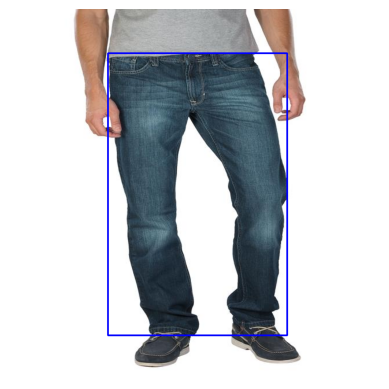

In [6]:
import cv2
import os
import matplotlib.pyplot as plt

def display_yolo_bbox_with_matplotlib(image_path, label_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return

    image_height, image_width = image.shape[:2]

    if not os.path.exists(label_path):
        print(f"Error: Label file {label_path} does not exist.")
        return

    with open(label_path, "r") as label_file:
        lines = label_file.readlines()

    for line in lines:
        values = line.strip().split()
        if len(values) < 5:
            print(f"Error: Invalid label format in {label_path}")
            continue

        class_id, x_center, y_center, width, height = map(float, values)

        x_center_pixel = int(x_center * image_width)
        y_center_pixel = int(y_center * image_height)
        width_pixel = int(width * image_width)
        height_pixel = int(height * image_height)

        x_min = int(x_center_pixel - width_pixel / 2)
        x_max = int(x_center_pixel + width_pixel / 2)
        y_min = int(y_center_pixel - height_pixel / 2)
        y_max = int(y_center_pixel + height_pixel / 2)

        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

# Example usage
image_path = yolo_dataset_dir + "39386.jpg"
label_path = yolo_dataset_dir + "39386.txt"
display_yolo_bbox_with_matplotlib(image_path, label_path)